In [3]:
import os
from blurred_data_prepare import data_processing, data_augmented
if not os.path.exists('dataset'): data_processing()
if not os.path.exists('augmented'): data_augmented()

from blurred_data_prepare import TRAIN_IMG_PATH, VAL_IMG_PATH, TEST_IMG_PATH, TRAIN_CAPTION_PATH, VAL_CAPTION_PATH, TEST_CAPTION_PATH, VOCAB_DIR, AUGMENTED_DIR
train_img_path = TRAIN_IMG_PATH
val_img_path = VAL_IMG_PATH
test_img_path =TEST_IMG_PATH

train_caption_path = TRAIN_CAPTION_PATH
val_caption_path = VAL_CAPTION_PATH
test_caption_path = TEST_CAPTION_PATH
augmented_dir = AUGMENTED_DIR
vocab_dir = VOCAB_DIR
model_path = "models/"  # Path where the trained model will be saved

import pickle
# Load vocabulary file
with open(vocab_dir, 'rb') as f: vocab = pickle.load(f)

# Create model directory
if not os.path.exists(model_path): os.makedirs(model_path)

In [4]:
# Hyper Parameters
batch_size = 16
learning_rate = 0.0001
num_epochs = 3

# Increase Model Capacity
embed_size = 256
hidden_size = 1024
num_layers = 1

In [5]:
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

val_transform = transforms.Compose([
    transforms.Resize(224),  # Adjust to the correct size for Inception
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([
    transforms.Resize(224),  # Adjust to the correct size for Inception
    transforms.ToTensor()
])

from blurred_data_loader import get_loader
# Declare data loaders
num_workers = 6
train_data_loader = get_loader(train_img_path, augmented_dir, train_caption_path, vocab, train_transform, batch_size, shuffle=True, num_workers=num_workers, testing=False, pin_memory=True)
val_data_loader = get_loader(val_img_path, "none", val_caption_path, vocab, val_transform, batch_size, shuffle=False, num_workers=num_workers, testing=False, pin_memory=True)
test_data_loader = get_loader(test_img_path, "none", test_caption_path, vocab, test_transform, batch_size, shuffle=False, num_workers=num_workers, testing=True, pin_memory=True)

In [7]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from model_vit_gpt2 import Encoder, Decoder # Import Model 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder(embed_size).to(device)
decoder = Decoder(embed_size, hidden_size, len(vocab), num_layers).to(device)

# 모델 가중치 로드
encoder.load_state_dict(torch.load('./predata/model_encoder.ckpt'))
decoder.load_state_dict(torch.load('./predata/model_decoder.ckpt'))

# Criterion with ignore_index to skip pad tokens
criterion = nn.CrossEntropyLoss(ignore_index=vocab('<pad>'))
params = list(decoder.parameters()) + list(encoder.linear.parameters()) # For ViT-GPT2
optimizer = torch.optim.Adam(params, lr=learning_rate)

# Gradient clipping value
clip_value = 10

In [8]:
from tqdm import tqdm

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()

    train_loss = 0  # 에포크 시작 전 훈련 손실 초기화
    with tqdm(enumerate(train_data_loader), total=len(train_data_loader), desc=f'Epoch {epoch + 1}/{num_epochs}') as t:
        for i, (images, captions, lengths) in t:
            # Move batch of images and captions to GPU if available
            images, captions = images.to(device), captions.to(device)

            # Forward pass through encoder and decoder
            features = encoder(images)
            outputs = decoder(features, captions, lengths)

            # outputs의 크기를 변환: (batch_size * sequence_length, vocab_size)
            outputs = outputs.reshape(-1, outputs.size(-1)) # for Vit-GPT2
            
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            # Calculate the batch loss based on the criterion
            loss = criterion(outputs, targets)
            train_loss += loss.item()  # 각 배치의 손실 누적
            decoder.zero_grad()
            encoder.zero_grad()

            # Backward pass (compute gradients)
            loss.backward()

            # Clip gradients
            clip_params = list(encoder.parameters()) + list(decoder.parameters())
            torch.nn.utils.clip_grad_norm_(clip_params, clip_value)
            # Update the weights
            optimizer.step()

            # Update tqdm's description with the current loss
            t.set_postfix(loss=loss.item())

        torch.save(decoder.state_dict(), os.path.join(model_path, 'art-decoder-{}.ckpt'.format(epoch+1)))
        torch.save(encoder.state_dict(), os.path.join(model_path, 'art-encoder-{}.ckpt'.format(epoch+1)))

Epoch 3/3: 100%|██████████| 1875/1875 [09:12<00:00,  3.39it/s, loss=0.846]


In [9]:
import torchtext.data.metrics as metrics

# 각 n-gram 수준(1-gram, 2-gram, 3-gram, 4-gram)에서 생성된 캡션과 참조 캡션 간의 일치도를 계산합니다.
def evaluate_model(model_idx):
    encoder_path = f'./models/art-encoder-{model_idx}.ckpt'
    decoder_path = f'./models/art-decoder-{model_idx}.ckpt'

    # 모델과 데이터 로더 설정
    encoder = Encoder(embed_size).to(device)
    decoder = Decoder(embed_size, hidden_size, len(vocab), num_layers).to(device)

    # 모델 가중치 로드
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))

    # 테스트 모드 설정
    encoder.eval()
    decoder.eval()

    def calculate_bleu(data_loader, encoder, decoder, vocab, device):
        predictions = []
        references = []
        with torch.no_grad():
            for images, captions, _ in data_loader:
                images = images.to(device)
                features = encoder(images)
                sampled_ids = decoder.sample(features)
                sampled_ids = sampled_ids.cpu().numpy()

                # Convert word_ids to words
                for i in range(len(images)):
                    sampled_caption = []
                    for word_id in sampled_ids[i]:
                        word = vocab.idx2word[word_id]
                        sampled_caption.append(word)
                        if word == '<end>':
                            break
                    predictions.append(sampled_caption[1:-1])

                    # Original sentence
                    orig_caption = []
                    for word_id in captions[i].numpy():
                        word = vocab.idx2word[word_id]
                        orig_caption.append(word)
                        if word == '<end>':
                            break
                    references.append([orig_caption[1:-1]])

        bleu1_score = metrics.bleu_score(predictions, references, max_n=4, weights=[1, 0, 0, 0])
        bleu2_score = metrics.bleu_score(predictions, references, max_n=4, weights=[0, 1, 0, 0])
        bleu3_score = metrics.bleu_score(predictions, references, max_n=4, weights=[0, 0, 1, 0])
        bleu4_score = metrics.bleu_score(predictions, references, max_n=4, weights=[0, 0, 0, 1])

        # 변경: BLEU 점수 계산 결과를 다른 변수에 할당
        return bleu1_score, bleu2_score, bleu3_score, bleu4_score

    # 모델의 일반화 능력 평가
    bleu_score = calculate_bleu(test_data_loader, encoder, decoder, vocab, device)
    for idx, bleu in enumerate(bleu_score):
        print(f'BLEU {idx + 1} Score: {round(bleu, 4)}')

for i in range(3):
    print(f"model: {i + 1}")
    evaluate_model(i + 1)

model: 1
BLEU 1 Score: 0.2909
BLEU 2 Score: 0.0893
BLEU 3 Score: 0.0319
BLEU 4 Score: 0.0128
model: 2
BLEU 1 Score: 0.2787
BLEU 2 Score: 0.082
BLEU 3 Score: 0.029
BLEU 4 Score: 0.0113
model: 3
BLEU 1 Score: 0.2733
BLEU 2 Score: 0.077
BLEU 3 Score: 0.0237
BLEU 4 Score: 0.0089


model: 1


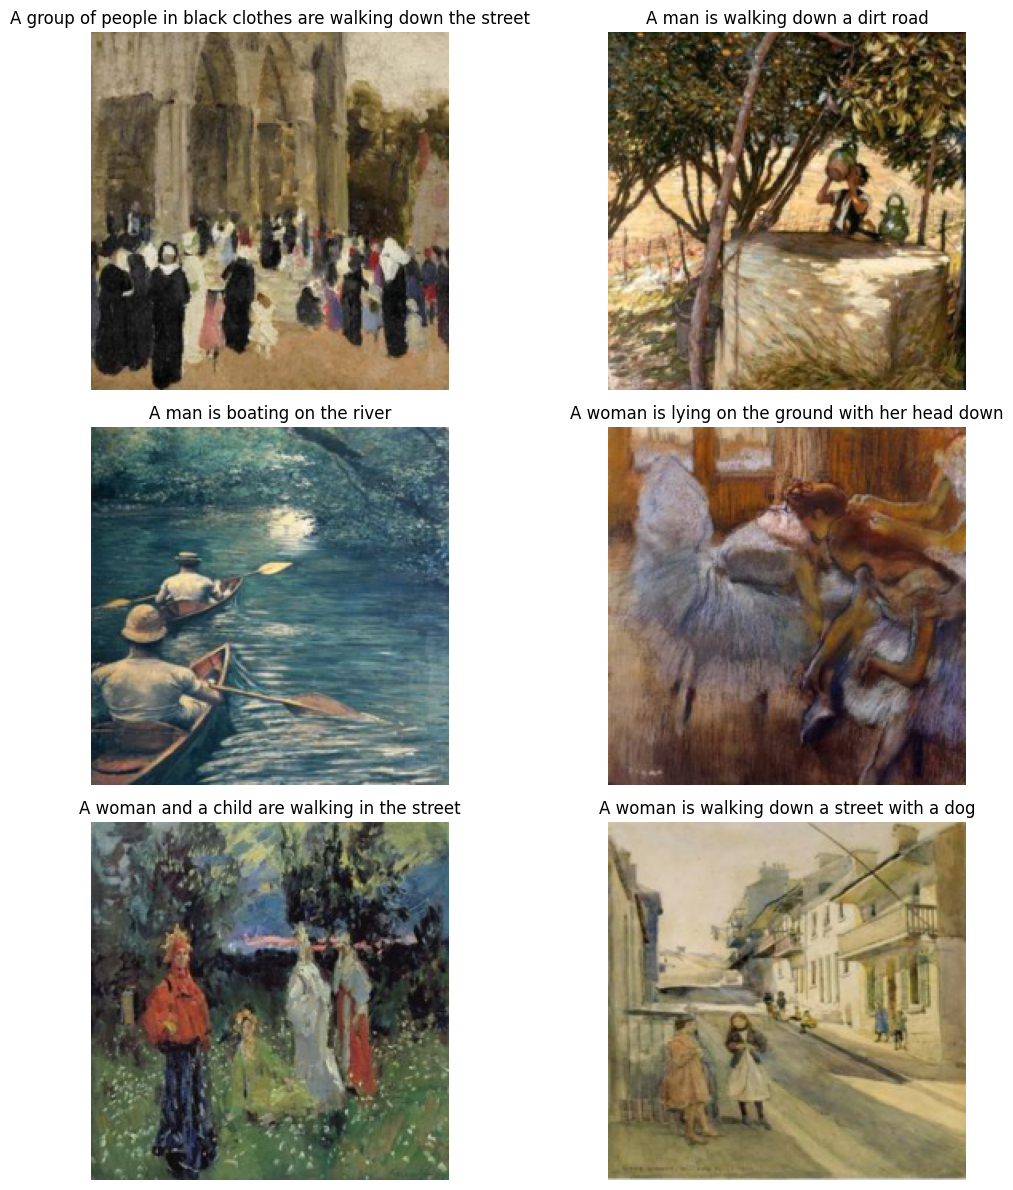

In [13]:
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image

def get_art_images(model_idx):
    encoder_path = f'./models/art-encoder-{model_idx}.ckpt'
    decoder_path = f'./models/art-decoder-{model_idx}.ckpt'

    # 모델과 데이터 로더 설정
    encoder = Encoder(embed_size).to(device)
    decoder = Decoder(embed_size, hidden_size, len(vocab), num_layers).to(device)

    # 모델 가중치 로드
    encoder.load_state_dict(torch.load(encoder_path))
    decoder.load_state_dict(torch.load(decoder_path))

    # 테스트 모드 설정
    encoder.eval()
    decoder.eval()

    # 테스트 데이터셋에서 랜덤으로 6개의 이미지 선택
    test_images = []
    for _ in range(6):
        idx = random.randint(0, len(test_data_loader.dataset) - 1)
        image, _ = test_data_loader.dataset[idx]
        test_images.append(image)
    
    # 이미지와 캡션 출력
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
    axes = axes.flatten()
    
    for i, image in enumerate(test_images):
        image = image.to(device)
        feature = encoder(image.unsqueeze(0))
        sampled_ids = decoder.sample(feature)
        sampled_ids = sampled_ids[0].cpu().numpy()
    
        # 캡션 변환
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            sampled_caption.append(word)
            if word == '<end>':
                break
        sentence = ' '.join(sampled_caption[1:-1]).capitalize()
    
        # 이미지 출력
        image = image.cpu().numpy().transpose((1, 2, 0))
        image = np.clip(image, 0, 1)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(sentence)
    
    plt.tight_layout()
    plt.show()

print(f"model: {1}")
get_art_images(0.2909)